In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#设置中文字体和负号显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

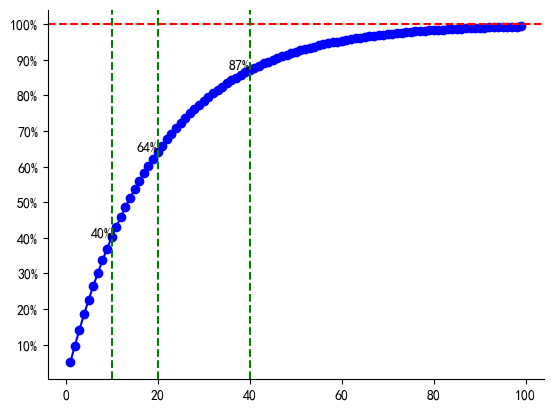

In [24]:
X = np.arange(1, 100, 1)
Y = 1 - pow(0.95, X)

plt.plot(X, Y, label='Y=1-0.95^X', color='blue', marker='o')
# 设置Y轴的标签格式为百分比
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# 设置Y轴的标签间隔为10%
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.1))
# 设置图片无边框
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


# 设置X=10时的Y值文本
plt.text(10, 1 - pow(0.95, 10), f'{1 - pow(0.95, 10):.0%}', fontsize=10, ha='right')
# 设置X=20时的Y值文本
plt.text(20, 1 - pow(0.95, 20), f'{1 - pow(0.95, 20):.0%}', fontsize=10, ha='right')

# 设置X=40时的Y值文本
plt.text(40, 1 - pow(0.95, 40), f'{1 - pow(0.95, 40):.0%}', fontsize=10, ha='right')
#设置 y = 1的水平线
plt.axhline(y=1, color='red', linestyle='--', label='y=1')
#设置 X = 10, 20, 40 的垂直线
plt.axvline(x=10, color='green', linestyle='--', label='x=10')
plt.axvline(x=20, color='green', linestyle='--', label='x=20')
plt.axvline(x=40, color='green', linestyle='--', label='x=40')

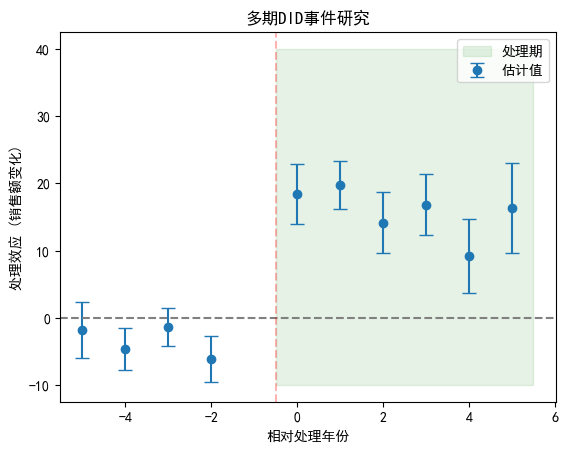

In [17]:
import pandas as pd
import numpy as np
import linearmodels as lm

# 生成模拟数据（100个公司，2010-2020年）
np.random.seed(42)
years = list(range(2010, 2021))
companies = [f'F{i}' for i in range(1, 101)]

data = []
for comp in companies:
    treat_year = np.random.choice([2014, 2016, 2018]) if np.random.rand() > 0.3 else 0  # 30%作为对照组
    base_sales = np.random.normal(100, 20)
    
    for year in years:
        time_trend = (year - 2010) * 5
        treated = 1 if treat_year > 0 and year >= treat_year else 0
        treatment_effect = np.random.normal(25, 5) * treated if treated else 0
        
        sales = base_sales + time_trend + treatment_effect + np.random.normal(0, 10)
        data.append({'company': comp, 'year': year, 
                     'treated': treated, 'sales': sales,
                     'treat_year': treat_year})

df = pd.DataFrame(data)
# 创建相对时间变量
df['rel_year'] = df.year - df.treat_year
df = df.set_index(['company', 'year'])



df.loc[df['treat_year'] == 0, 'rel_year'] = -999  # 对照组标记

# 多期DID回归（事件研究法）
df_events = df.copy()
for yr in range(-5, 6):  # 生成-5到5期虚拟变量
    if yr != -1:  # 省略-1期作为基准
        df_events[f'd_{yr}'] = (df_events['rel_year'] == yr).astype(int)

formula = "sales ~ 1 + " + " + ".join([f"`d_{yr}`" for yr in range(-5,6) if yr != -1]) 
formula += " + EntityEffects + TimeEffects"

model = lm.PanelOLS.from_formula(formula, df_events.dropna())
results = model.fit(cov_type='clustered', cluster_entity=True)

# 提取事件研究结果
coefs = pd.DataFrame({
    'time': [t for t in range(-5, 6) if t != -1],
    'coef': results.params[1:16].values,
    'se': results.std_errors[1:16].values
})

# 绘制事件研究图
import matplotlib.pyplot as plt
plt.errorbar(coefs['time'], coefs['coef'], yerr=1.96*coefs['se'], 
             fmt='o', capsize=5, label='估计值')
plt.axhline(y=0, color='grey', linestyle='--')
plt.axvline(x=-0.5, color='red', linestyle='--', alpha=0.3)
plt.fill_between([-0.5, 5.5], -10, 40, color='green', alpha=0.1, label='处理期')
plt.xlabel('相对处理年份')
plt.ylabel('处理效应 (销售额变化)')
plt.title('多期DID事件研究')
plt.legend()
plt.show()

In [18]:
df

treated       sales  treat_year  rel_year
company year                                           
F1      2010        0  104.720566        2014        -4
        2011        0  103.896799        2014        -3
        2012        0  142.291448        2014        -2
        2013        0  124.928653        2014        -1
        2014        1  142.378419        2014         0
...               ...         ...         ...       ...
F100    2016        0  151.142852        2018        -2
        2017        0  163.829933        2018        -1
        2018        1  184.607576        2018         0
        2019        1  206.426887        2018         1
        2020        1  203.416405        2018         2

[1100 rows x 4 columns]

In [36]:
df = df.assign(treat=lambda tmp: tmp.treat_year.apply(lambda x: 1 if x > 0 else 0))\
    .assign(treat_after=lambda tmp: (tmp.treat_year <= tmp.index.get_level_values('year')).astype(int))


In [37]:
df

treated       sales  treat_year  rel_year  treat  treat_after
company year                                                               
F1      2010        0  104.720566        2014        -4      1            0
        2011        0  103.896799        2014        -3      1            0
        2012        0  142.291448        2014        -2      1            0
        2013        0  124.928653        2014        -1      1            0
        2014        1  142.378419        2014         0      1            1
...               ...         ...         ...       ...    ...          ...
F100    2016        0  151.142852        2018        -2      1            0
        2017        0  163.829933        2018        -1      1            0
        2018        1  184.607576        2018         0      1            1
        2019        1  206.426887        2018         1      1            1
        2020        1  203.416405        2018         2      1            1

[1100 rows x 6 columns]

In [ ]:
df.groupby(['treat', 'treat_after']).size()

treat  treat_after
0      0              242
1      0              304
       1              554
dtype: int64

In [43]:
lm.PanelOLS.from_formula("sales ~  1+  treat_after + EntityEffects + TimeEffects", df.dropna(),drop_absorbed=True).fit(cov_type='clustered', cluster_entity=True)

Dep. Variable:,sales,R-squared:,0.3151
Estimator:,PanelOLS,R-squared (Between):,-0.1702
No. Observations:,1100,R-squared (Within):,0.4992
Date:,"Sat, Aug 02 2025",R-squared (Overall):,0.2507
Time:,21:56:52,Log-likelihood,-4091.3
Cov. Estimator:,Clustered,,
,,F-statistic:,455.03
Entities:,100,P-value,0.0000
Avg Obs:,11.000,Distribution:,"F(1,989)"
Min Obs:,11.000,,
Max Obs:,11.000,F-statistic (robust):,354.73


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


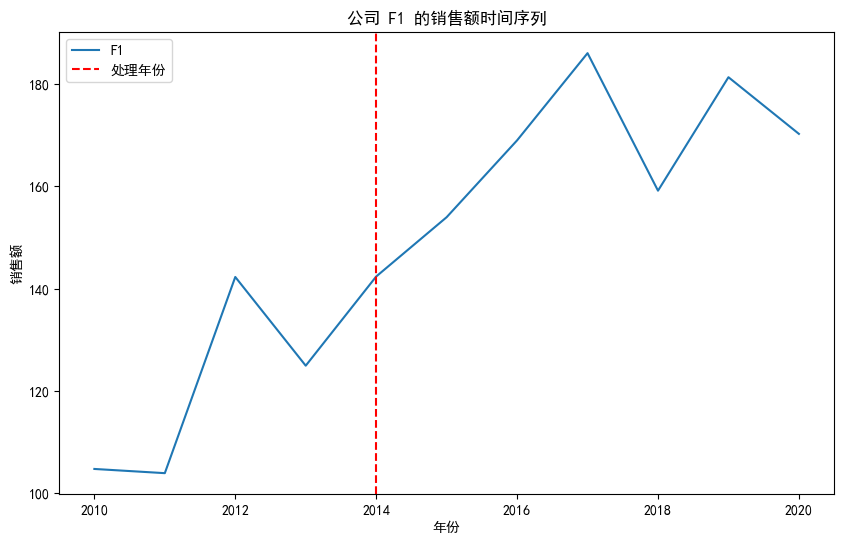

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


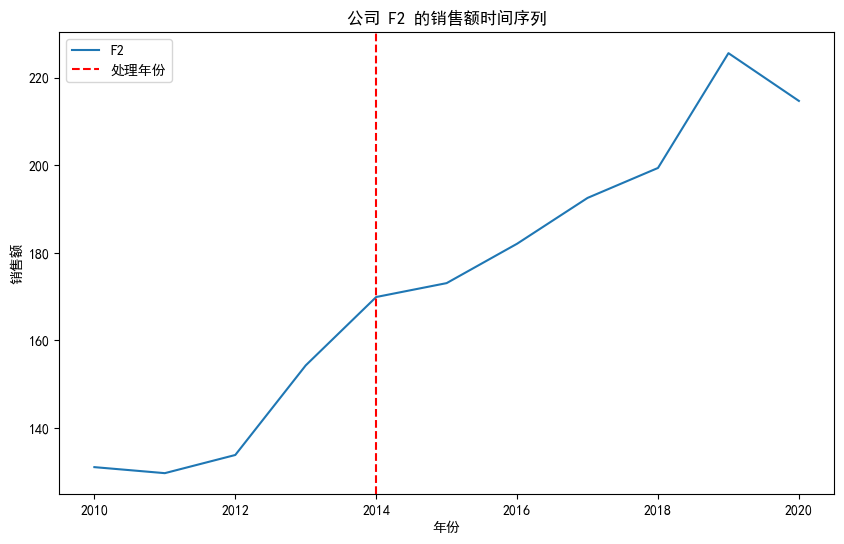

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


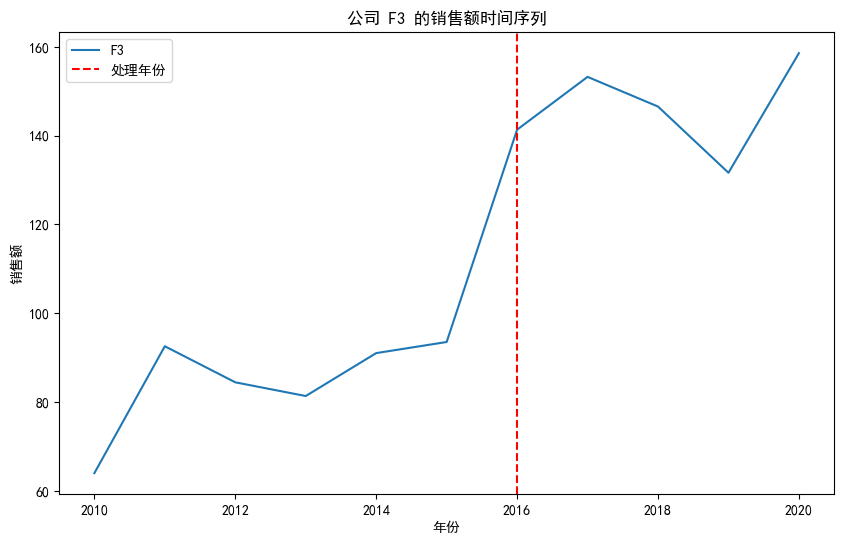

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


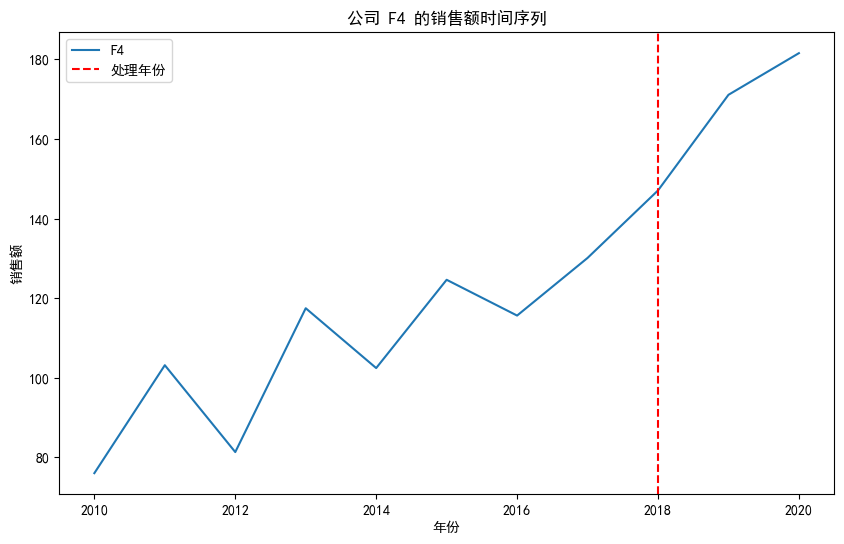

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


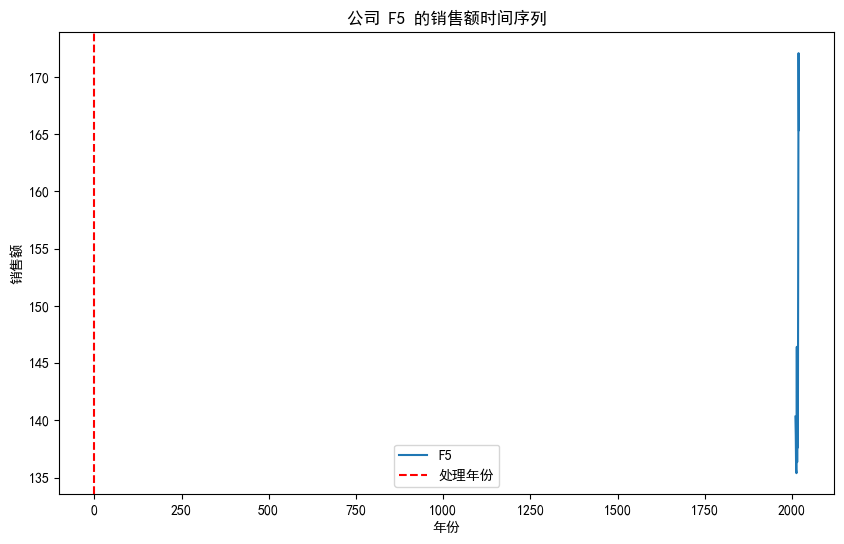

In [32]:
# 针对没个个体生成时间序列图
import matplotlib.pyplot as plt
import seaborn as sns   
# 选择每个公司进行绘制
companies_to_plot = df.index.get_level_values('company').unique()[:5]  # 选择前5个公司
for company in companies_to_plot:
    company_data = df.xs(company, level='company')
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=company_data.reset_index(), x='year', y='sales', label=company)
    plt.axvline(x=company_data['treat_year'].iloc[0], color='red', linestyle='--', label='处理年份')
    plt.title(f'公司 {company} 的销售额时间序列')
    plt.xlabel('年份')
    plt.ylabel('销售额')
    plt.legend()
    plt.show()